# Correlation coefficients

In [24]:
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt

from astroML.stats.random import bivariate_normal
from astroML.utils.decorators import pickle_results

# percent sign must be escaped if usetex=True
import matplotlib
if matplotlib.rcParams.get('text.usetex'):
    pct = '\%'
else:
    pct = '%'
    
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)

Given two data sets of equal size $N$, ${x_i}$ and ${y_i}$, Pearson's sample correlation coefficient is

$$r = \frac{\sum_{i=1}^{N}(x_i-\bar{x})(y_i-\bar{y})}{\sqrt{\sum_{i=1}^{N}(x_i-\bar{x})^2}\sqrt{\sum_{i=1}^{N}(y_i-\bar{y})^2}}$$

where $-1 \leq r \leq 1$. If the variables are uncorrelated, $r=0$.

First we will define the our parameters for the distributions.

In [3]:
Nbootstraps = 5000
N = 1000

sigma1 = 2.0
sigma2 = 1.0
mu = (10.0, 10.0)
alpha_deg = 45.0
alpha = alpha_deg * np.pi / 180
f = 0.01

Next we will create our sample of the distribution with and without outliers. We get rho_true from pearson/spearman r and tau_true from Eq. 41 of arXiv:1011.2009

In [11]:
np.random.seed(0)
X = bivariate_normal(mu, sigma1, sigma2, alpha, N)

X_out = X.copy()
X_out[:int(f * N)] = bivariate_normal(mu, 2, 5,
                                      45 * np.pi / 180., int(f * N))

rho_true = 0.6
tau_true = 2 / np.pi * np.arcsin(rho_true)

Next we create a function to compute the statistics.  Since this takes a while, we'll use the "pickle_results" decorator to save the results of the computation to disk.

In [20]:
@pickle_results('fig_correlations_dump.pkl')
def compute_results(N, Nbootstraps):
    results = np.zeros((3, 2, Nbootstraps))

    for k in range(Nbootstraps):
        ind = np.random.randint(N, size=N)
        for j, data in enumerate([X, X_out]):
            x = data[ind, 0]
            y = data[ind, 1]
            for i, statistic in enumerate([stats.pearsonr,
                                           stats.spearmanr,
                                           stats.kendalltau]):
                results[i, j, k] = statistic(x, y)[0]

    return results

results = compute_results(N, Nbootstraps)

@pickle_results: using precomputed results from 'fig_correlations_dump.pkl'


Next, we will plot the results

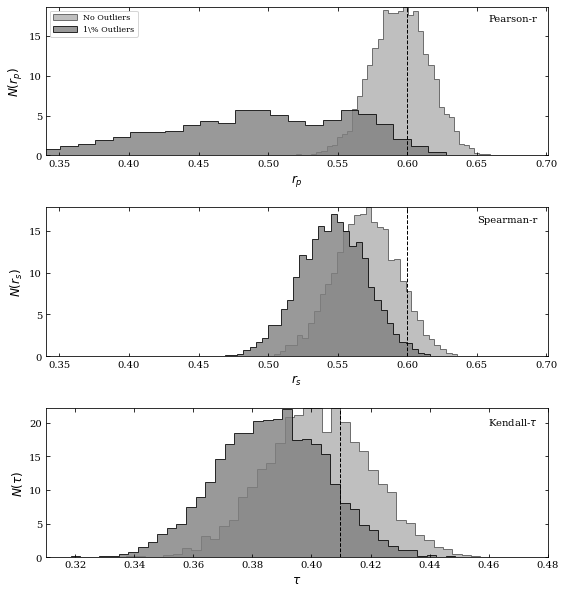

In [35]:
fig = plt.figure(figsize=(9, 9))
fig.subplots_adjust(bottom=0.1, top=0.95, hspace=0.35)

histargs = (dict(alpha=0.5, label='No Outliers'),
            dict(alpha=0.8, label='%i%s Outliers' % (int(f * 100), pct)))

distributions = ['Pearson-r', 'Spearman-r', r'Kendall-$\tau$']
xlabels = ['r_p', 'r_s', r'\tau']\

for i in range(3):
    ax = fig.add_subplot(311 + i)
    for j in range(2):
        ax.hist(results[i, j], 40, histtype='stepfilled', fc='gray',
                density=True, **histargs[j])

    if i == 0:
        ax.legend(loc=2)

    ylim = ax.get_ylim()
    if i < 2:
        ax.plot([rho_true, rho_true], ylim, '--k', lw=1)
        ax.set_xlim(0.34, 0.701)
    else:
        ax.plot([tau_true, tau_true], ylim, '--k', lw=1)
        ax.set_xlim(0.31, 0.48)
    ax.set_ylim(ylim)

    ax.text(0.98, 0.95, distributions[i], ha='right', va='top',
            transform=ax.transAxes,fontsize = 10)

    ax.set_xlabel('$%s$' % xlabels[i], fontsize = 12)
    ax.set_ylabel('$N(%s)$' % xlabels[i],fontsize = 12)
    ax.tick_params(axis='both', which='major', labelsize=10)

plt.show()